  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


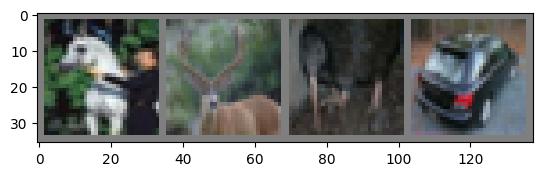

Epoch [1/5], Step [2000/12500], Loss: 2.2690
Epoch [1/5], Step [4000/12500], Loss: 2.2545
Epoch [1/5], Step [6000/12500], Loss: 2.3041
Epoch [1/5], Step [8000/12500], Loss: 2.3005
Epoch [1/5], Step [10000/12500], Loss: 2.2813
Epoch [1/5], Step [12000/12500], Loss: 2.2738
Epoch [2/5], Step [2000/12500], Loss: 2.3213
Epoch [2/5], Step [4000/12500], Loss: 2.3590
Epoch [2/5], Step [6000/12500], Loss: 1.7573
Epoch [2/5], Step [8000/12500], Loss: 2.3187
Epoch [2/5], Step [10000/12500], Loss: 1.9580
Epoch [2/5], Step [12000/12500], Loss: 1.7337
Epoch [3/5], Step [2000/12500], Loss: 3.1726
Epoch [3/5], Step [4000/12500], Loss: 1.4447
Epoch [3/5], Step [6000/12500], Loss: 2.0649
Epoch [3/5], Step [8000/12500], Loss: 0.9555
Epoch [3/5], Step [10000/12500], Loss: 1.3870
Epoch [3/5], Step [12000/12500], Loss: 2.2205
Epoch [4/5], Step [2000/12500], Loss: 3.8334
Epoch [4/5], Step [4000/12500], Loss: 2.0714
Epoch [4/5], Step [6000/12500], Loss: 0.9779
Epoch [4/5], Step [8000/12500], Loss: 1.8386
Epoc

In [7]:
""" 
- there is a reason why in pytorch we don't use softamx in last activatoin layer when combined with CrossEntropyLoss() 

given shape as parameter to a funciton like this (shpae=(1,2,3))
and then you want to speard the value of it you can use (bs, *shape) this == (bs, 1, 2, 3)

# imoprtant notes
- when we define the network architecture we should think of the shapes as individual inputs 
- in the forward function we will think of giving it a batch of inputs

# important function 
    torch.utils.data.random_split(full_dataset, [train_size, val_size]) : train_size and val sizer can be like : 0.2 0.8
    this returns a subset and not a dataset object , so that's a problem though

# torch.view() : reshapes but (without altering the order of the dimnesion)
# use : torch.permute(1,2,0) (this means the 0 dimension will be in third dimension, and first dimension will be in 0 dimension and second dimension will be in first dimension)
    - to turn a pytorch tensor after the transofmration.compos back again to an img you don't have to use view() 

    
View changes how the tensor is represented. For ex: a tensor with 4 elements can be represented as 4X1 or 2X2 or 1X4 but permute changes the axes. 
While permuting the data is moved but with view data is not moved but just reinterpreted.

Compose means that it will combine the transformations 
    transforms.compose(List[transformations]) : you gotta make sure your image be turned to tensor first lol 
"""

import torch    
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False
)

classes = (
    'plane', # 0
    'car', # 1
    'bird', # 2
    'cat',# 3
    'deer', # 4
    'dog', # 5
    'frog', # 6
    'horse', # 7
    'ship', # 8
    'truck'
) # I am using a tuply because I

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input_channels, output_channels, kernel_size, ...etc
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5

        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'

torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0

    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]


    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

In [1]:
# check this out from : https://discuss.pytorch.org/t/inferring-shape-via-flatten-operator/138/3
# where you can infern the output shape of the convolutions to passe it to the input like this 


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        n_size = self._get_conv_output(input_shape)
        
        self.fc1 = nn.Linear(n_size, 50)
        self.fc2 = nn.Linear(50, 10)

    def _forward_features(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        return x


    # generate input sample and forward to get shape
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
    
        # or shoould I just do 

    
    # when we forward a batch of features
    def forward(self, x):
        x = self._forward_features(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

In [6]:
model = Net()

input_features = model.fc1.in_features
print('input features : ', input_features)



input features :  320


In [31]:
w = torch.tensor([0,1,2,3], dtype=torch.float32, requires_grad=True)

x = torch.tensor([0.2, 0.3, 0.4 , 0.5], dtype=torch.float32)
x2 = torch.tensor([0.1, 0.2, 0.3, 0.4], dtype=torch.float32)


y_hat = w.T @ x
y_hat2 = w.T @ x2

In [45]:
y_hat = w.T @ x

In [46]:
y_hat
loss =(2-y_hat)
loss.backward()


In [50]:
w.grad.zero_()

tensor([0., 0., 0., 0.])

In [51]:
w.grad

tensor([0., 0., 0., 0.])

In [11]:
import numpy as np 

img = np.random.randint(5, size=(128, 128, 3))

img.shape

(128, 128, 3)

In [13]:
from torchvision.transforms import transforms

res_img = transforms.ToTensor()(img)
res_img.shape

torch.Size([3, 128, 128])

In [ ]:
# tesnor basics 

torch.tensor(, dtype=torch.in32)
t.item()
t.data()
troch.randint()
is_lef
.grad._zerro()
.grad
.backward() 



# gradients of a tensor
    requires_grad = True 
    with torch.autog_grad(bool_expression)
    with  torch.set_grad_enabled(False)
    torch.max()
    torch.min()


dataset 
get_item 
len 
get_items


trochvision.






